In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

#to ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv("data/IHME-GBD_2019_DATA-daf40202-1.csv")
data_rate = pd.read_csv('data/by_Rate.csv')
data_number = pd.read_csv('data/by_Number.csv')
data_percent = pd.read_csv('data/by_Percent.csv')

In [8]:
def write_to_html(cancer_name, graph_name,fig):
    cancer = cancer_name.replace(",", "")
    cancer = cancer.replace(" ", "-")
    #cwd = os.getcwd()
    if not os.path.exists(f"graphs_html/{cancer}"):
        os.makedirs(f"graphs_html/{cancer}")
    fig.write_html(f"graphs_html/{cancer}/{graph_name}.html")

In [9]:
def write_to_png(cancer_name, graph_name, fig):
    cancer = cancer_name.replace(",", "")
    cancer = cancer.replace(" ", "-")
    #cwd = os.getcwd()
    if not os.path.exists(f"graphs/{cancer}"):
        os.makedirs(f"graphs/{cancer}")
    fig.write_image(f"graphs/{cancer}/{graph_name}.png")

# Line Plot
DALY\'s rate per 100k population vs Average percentage of {cancer} deaths relative to deaths from all causes, from 1990 to 2019. <br>
Arrows indicate the chronological order, each arrow indicating numbers for a period of 5 years.

In [11]:
# Define the year groups
year_groups = {
    '1990-1994': list(range(1990, 1995)),
    '1995-1999': list(range(1995, 2000)),
    '2000-2004': list(range(2000, 2005)),
    '2005-2009': list(range(2005, 2010)),
    '2010-2014': list(range(2010, 2015)),
    '2015-2019': list(range(2015, 2020))
}

# Function to assign each year to a group
def map_year_to_group(year):
    for group, years in year_groups.items():
        if year in years:
            return group
    return None

for cancer in data_percent.cause_name.unique():
    data_processed_n= data_percent.copy()
    data_processed_r = data_rate.copy()
    data_processed_n = data_processed_n[data_processed_n.cause_name==cancer]
    data_processed_r = data_processed_r[data_processed_r.cause_name==cancer]
    data_processed_n['year_group'] = data_processed_n['year'].apply(map_year_to_group)
    data_processed_r['year_group'] = data_processed_r['year'].apply(map_year_to_group)
    data_processed_n["categories"] = data_processed_n.sex_name + "/" + data_processed_n.location_name
    data_processed_r["categories"] = data_processed_r.sex_name + "/" + data_processed_r.location_name
    data_p_daly = data_processed_r[data_processed_r.measure_name=='DALYs (Disability-Adjusted Life Years)']
    data_p_daly = data_p_daly.groupby(['year_group','categories'])['val'].mean().reset_index()
    data_p_deaths = data_processed_n[data_processed_n.measure_name=='Deaths']
    data_p_deaths = data_p_deaths.groupby(['year_group','categories'])['val'].mean().reset_index()
    data_joined = data_p_daly.join(data_p_deaths.set_index(['year_group','categories']), on=['year_group','categories'],rsuffix='_deaths')
    data_joined.dropna(inplace=True)
    fig = px.line(data_joined, y="val_deaths", x="val", 
                    line_group="categories", 
                    symbol='categories', 
                    color='categories',
                    hover_name="categories",
                    line_shape='spline',
                    labels=dict(
                            val="DALYs Rate", 
                            val_deaths="Percent Deaths",
                            categories="Sex/Location",
                            year_group="Years"),
                    color_discrete_sequence=[px.colors.qualitative.Antique[1],px.colors.qualitative.Antique[2],px.colors.qualitative.Antique[4],px.colors.qualitative.Antique[5]],
                    #color_discrete_sequence=px.colors.qualitative.Antique,
                    hover_data={'categories':False,
                             'val':':.2f',
                             'val_deaths':':.2f',
                             'year_group':True,}
                    )
    fig.update_traces(marker=dict(size=10,symbol= "arrow-bar-up", angleref="previous"),)
    fig.update_layout(
                    legend=dict(
                            yanchor="auto",
                            y=0.99,
                            xanchor="auto",
                            x=0.01,
                            bgcolor="rgba(0,0,0,0)"),
                        title=dict(text=f'DALY\'s rate per 100k population vs Average percentage of {cancer} deaths relative to deaths from all causes,<br> from 1990 to 2019.'),
                        )
    #write_to_html(cancer,'DALYvDeaths',fig)
    write_to_png(cancer,'DALYvDeaths',fig)
    #fig.show()

# Horizontal bar plot
Deaths Rate per age category

In [ ]:
sorted_age_names = ['<5 years', '5-14 years', '15-19 years', '20-24 years', '25-29 years',
                    '30-34 years', '35-39 years', '40-44 years', '45-49 years', '50-54 years',
                    '55-59 years', '60-64 years', '65-69 years', '70-74 years', '75+ years']
sorted_age_names.reverse()

for cancer in data_rate.cause_name.unique():
        data_processed = data_rate.groupby(['year','sex_name','cause_name','measure_name','age_name'])['val'].mean().reset_index()
        data_processed = data_processed[data_processed.cause_name==f'{cancer}']
        data_processed = data_processed[(data_processed.age_name!='25-49 years') & (data_processed.age_name!='50-69 years')]
        data_processed = data_processed.fillna(0)
        fig = px.bar(data_processed[(data_processed.measure_name=='Deaths')], y="age_name", x="val", 
                color="sex_name", 
                animation_frame="year",
                hover_name="sex_name",
                barmode='stack',
                orientation='h',
                labels=dict(
                        age_name="Age",
                        val="Deaths Rate",
                        sex_name="Sex",
                        year="Year"),
                color_discrete_sequence=[px.colors.qualitative.Antique[1],px.colors.qualitative.Antique[4]],
                hover_data={'sex_name':False,
                                'val':':.2f',
                                'age_name':True,
                                'year':True,},
                category_orders={"age_name": sorted_age_names,}
                )
        fig.update_layout(#xaxis={'categoryorder':'category descending'},
                        legend=dict(
                                yanchor="bottom",
                                y=0.01,
                                xanchor="right",
                                x=0.99,
                                bgcolor="rgba(0,0,0,0)"),
                                title=dict(text=f'Deaths rate per 100k population per age categories, from 1990 to 2019.'),
                                )
        #write_to_html(cancer,'Hbar',fig)
        write_to_png(cancer,'Hbar',fig)
        #fig.show()

# Multiple bar plot
Incidence, Prevalence and deaths absolute numbers per age and sex

In [ ]:
for cancer in data_rate.cause_name.unique():
    data_processed = data_rate.copy()
    data_processed['year'] = data_processed['year'].apply(map_year_to_group)
    data_processed = data_processed.groupby(['year','sex_name','cause_name','measure_name'])['val'].mean().reset_index()
    data_processed = data_processed[data_processed.cause_name==f'{cancer}']

    data_joined = data_processed[(data_processed.measure_name=='Incidence') | (data_processed.measure_name=='Prevalence') | (data_processed.measure_name=='Deaths')]
    data_joined["categories"] = data_joined.sex_name + "/" + data_joined.measure_name
    data_joined['val_scaled'] = data_joined.val.apply(lambda x : x/100000)

    fig = px.bar(data_joined,x='year',y='val',color='categories',
                barmode='group',
                hover_name="categories",
                labels=dict(
                            categories="Sex/Measure",
                            sex_name="Sex",
                            measure_name="Measure",
                            year="Years"),
                color_discrete_sequence=px.colors.qualitative.Antique[1:],
                hover_data={'categories':False,
                                'sex_name':False,
                                'measure_name':False,
                                'year':True,
                                'val':':.2f',
                                },
                category_orders={"categories": ['Female/Prevalence','Female/Incidence','Female/Deaths','Male/Deaths', 'Male/Incidence','Male/Prevalence'],}
                )
    fig.update_layout(
        title="Incidence, Prevalence and Deaths Rates per 100k population averaged across all age groups",
        yaxis_title="Rate",
        bargroupgap=0.1,
        )
    #write_to_html(cancer,'Vbar',fig)
    write_to_png(cancer,'Vbar',fig)
    #fig.show()

# Line plot
Proportion of deaths caused by cancer vs Time

In [ ]:
data_processed = data_percent.copy()
data_processed['val'] = data_processed['val'].apply(lambda x : round(x, 3))
for cancer in data_rate.cause_name.unique():
    fig = go.Figure()
    colors = px.colors.qualitative.Antique
    fill_colors = [c[:3] + 'a' + c[3:-1] + ', 0.2)' for c in px.colors.qualitative.Antique]
    i=0
    for location, group_l in data_processed[(data_processed.measure_name=='Deaths') & (data_processed.cause_name==f'{cancer}')].groupby(['location_name','sex_name','year'])[['val','lower','upper']].mean().reset_index().groupby('location_name'):
        for sex, group_s in group_l.groupby('sex_name'):
            fig.add_trace(go.Scatter(x=group_s['year'], y=group_s['val'], name=f'{sex}/{location}' ,line_color=colors[i],
                                     #customdata=np.dstack((z1, z3)),
                                     #hovertemplate='<b>{x}</b><br>%{name[0]}:%{y:.3f}<br>z3:%{customdata[1]:.3f} ',
                                     ))
            fig.add_trace(go.Scatter(x=group_s['year'], y=group_s['lower'], fill=None, mode='lines',hoverinfo='skip',line_color=colors[i],line_width=0.1,showlegend=False))
            fig.add_trace(go.Scatter(x=group_s['year'], y=group_s['upper'], fill='tonexty', mode='lines',hoverinfo='skip',
                                    line_color=colors[i],line_width=0.1,showlegend=False,fillcolor=fill_colors[i],))
            i+=1
    fig.update_xaxes(title_text="Year")
    fig.update_yaxes(title_text="Percent out of all death causes")
    fig.update_layout(hovermode='x unified', title=f'Average proportion of deaths caused by {cancer} relative to deaths from all causes, from 1990 to 1019',
                        legend=dict(
                                yanchor="top",
                                y=0.99,
                                xanchor="right",
                                x=0.99,
                                bgcolor="rgba(0,0,0,0)"),
                                
                    )
    #write_to_html(cancer,'TimeSeries',fig)
    write_to_png(cancer,'TimeSeries',fig)
    #fig.show()

# WordCloud

In [11]:
from wordcloud import WordCloud

In [3]:
data_rate.head()

,Unnamed: 0,measure_id,measure_name,location_id,location_name,sex_id,sex_name,age_id,age_name,cause_id,cause_name,metric_id,metric_name,year,val,upper,lower
0,314555,6,Incidence,94,Switzerland,2,Female,25,50-69 years,471,Kidney cancer,3,Rate,1990,5.280548,6.157606,4.490293
1,314554,6,Incidence,94,Switzerland,1,Male,25,50-69 years,471,Kidney cancer,3,Rate,1990,17.371771,19.240313,15.491265
2,314375,6,Incidence,94,Switzerland,2,Female,23,5-14 years,471,Kidney cancer,3,Rate,1990,0.332313,0.475210,0.228831
3,314374,6,Incidence,94,Switzerland,1,Male,23,5-14 years,471,Kidney cancer,3,Rate,1990,0.287622,0.375987,0.212785
4,314195,6,Incidence,94,Switzerland,2,Female,19,70-74 years,471,Kidney cancer,3,Rate,1990,12.385557,15.692373,9.520635


In [231]:
data_clouds = data_rate[data_rate['measure_name']=='Deaths'].groupby(['sex_name','cause_name'])['val'].mean().reset_index()

In [232]:
data_clouds_women = data_clouds[data_clouds['sex_name']=='Female']
data_clouds_men = data_clouds[data_clouds['sex_name']=='Male']

In [234]:
sup = {'cause_name': ['lorem ipsum cancer' for i in range(7000)], 'val': [1.5 for i in range(7000)]}
sup_df = pd.DataFrame(data=sup)
sup_df.head(1)

,cause_name,val
0,lorem ipsum cancer,1.5


In [235]:
data_clouds_men = pd.concat([sup_df,data_clouds_men],ignore_index=True)
data_clouds_women = pd.concat([sup_df,data_clouds_women],ignore_index=True)

In [236]:
data_clouds_men['val']=(data_clouds_men.val-data_clouds_men.val.min())/(data_clouds_men.val.max()-data_clouds_men.val.min())
data_clouds_women['val']=(data_clouds_women.val-data_clouds_women.val.min())/(data_clouds_women.val.max()-data_clouds_women.val.min())

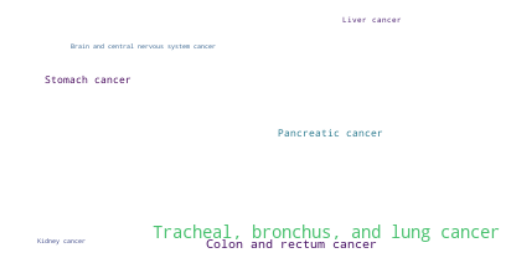

In [238]:
# create word cloud
wc = WordCloud(background_color='white')
wc.generate_from_frequencies(data_clouds_men.set_index('cause_name')['val'])

# plot
plt.figure()
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()

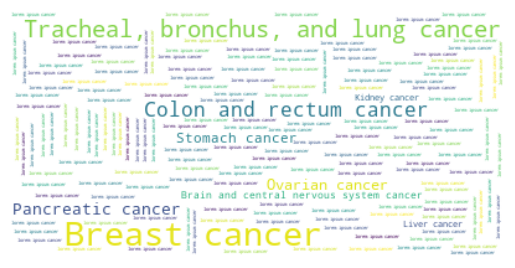

In [239]:
# create word cloud
wc = WordCloud(background_color='white')
wc.generate_from_frequencies(data_clouds_women.set_index('cause_name')['val'])

# plot
plt.figure()
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()